# Air Quality

In [1]:
import pandas as pd, numpy as np, missingno as msno, matplotlib.pyplot as plt
from utils import setup_project_root
setup_project_root()
air = pd.read_csv("data/air-quality.csv")

## Identify dtypes and basic info

In [2]:
air.dtypes

Date      object
Ozone    float64
Solar    float64
Wind     float64
Temp       int64
dtype: object

In [3]:
air

,Date,Ozone,Solar,Wind,Temp
0,1976-05-01,41.0,190.0,7.4,67
1,1976-05-02,36.0,118.0,8.0,72
2,1976-05-03,12.0,149.0,12.6,74
3,1976-05-04,18.0,313.0,11.5,62
4,1976-05-05,NaN,NaN,14.3,56
...,...,...,...,...,...
148,1976-09-26,30.0,193.0,6.9,70
149,1976-09-27,NaN,145.0,13.2,77
150,1976-09-28,14.0,191.0,14.3,75
151,1976-09-29,18.0,131.0,8.0,76


In [4]:
## convert date to date
air['Date'] = pd.to_datetime(air['Date'], format='%Y-%m-%d')

## Make new variables
1. Season
2. Month year

In [5]:
from datetime import datetime

def month_year(d):
    if pd.isna(d):
        return None
    else:
        return f'{d.month}-{d.year}'


def season(d):
    if pd.isna(d):
        return None
    else:
        month = d.month  # already a pandas/NumPy datetime; no manual epoch math needed
        if month in [9, 10, 11]:
            return 'Autumn'
        elif month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        else:
            return 'Summer'
        
air['MY'] = air['Date'].transform(month_year)
air['Season'] = air['Date'].transform(season)

In [6]:
air

,Date,Ozone,Solar,Wind,Temp,MY,Season
0,1976-05-01,41.0,190.0,7.4,67,5-1976,Spring
1,1976-05-02,36.0,118.0,8.0,72,5-1976,Spring
2,1976-05-03,12.0,149.0,12.6,74,5-1976,Spring
3,1976-05-04,18.0,313.0,11.5,62,5-1976,Spring
4,1976-05-05,NaN,NaN,14.3,56,5-1976,Spring
...,...,...,...,...,...,...,...
148,1976-09-26,30.0,193.0,6.9,70,9-1976,Autumn
149,1976-09-27,NaN,145.0,13.2,77,9-1976,Autumn
150,1976-09-28,14.0,191.0,14.3,75,9-1976,Autumn
151,1976-09-29,18.0,131.0,8.0,76,9-1976,Autumn


In [7]:
air.shape

(153, 7)

In [8]:
# x - mu / sd(x) /sqrt(n)

## Check for missing data

<Axes: >

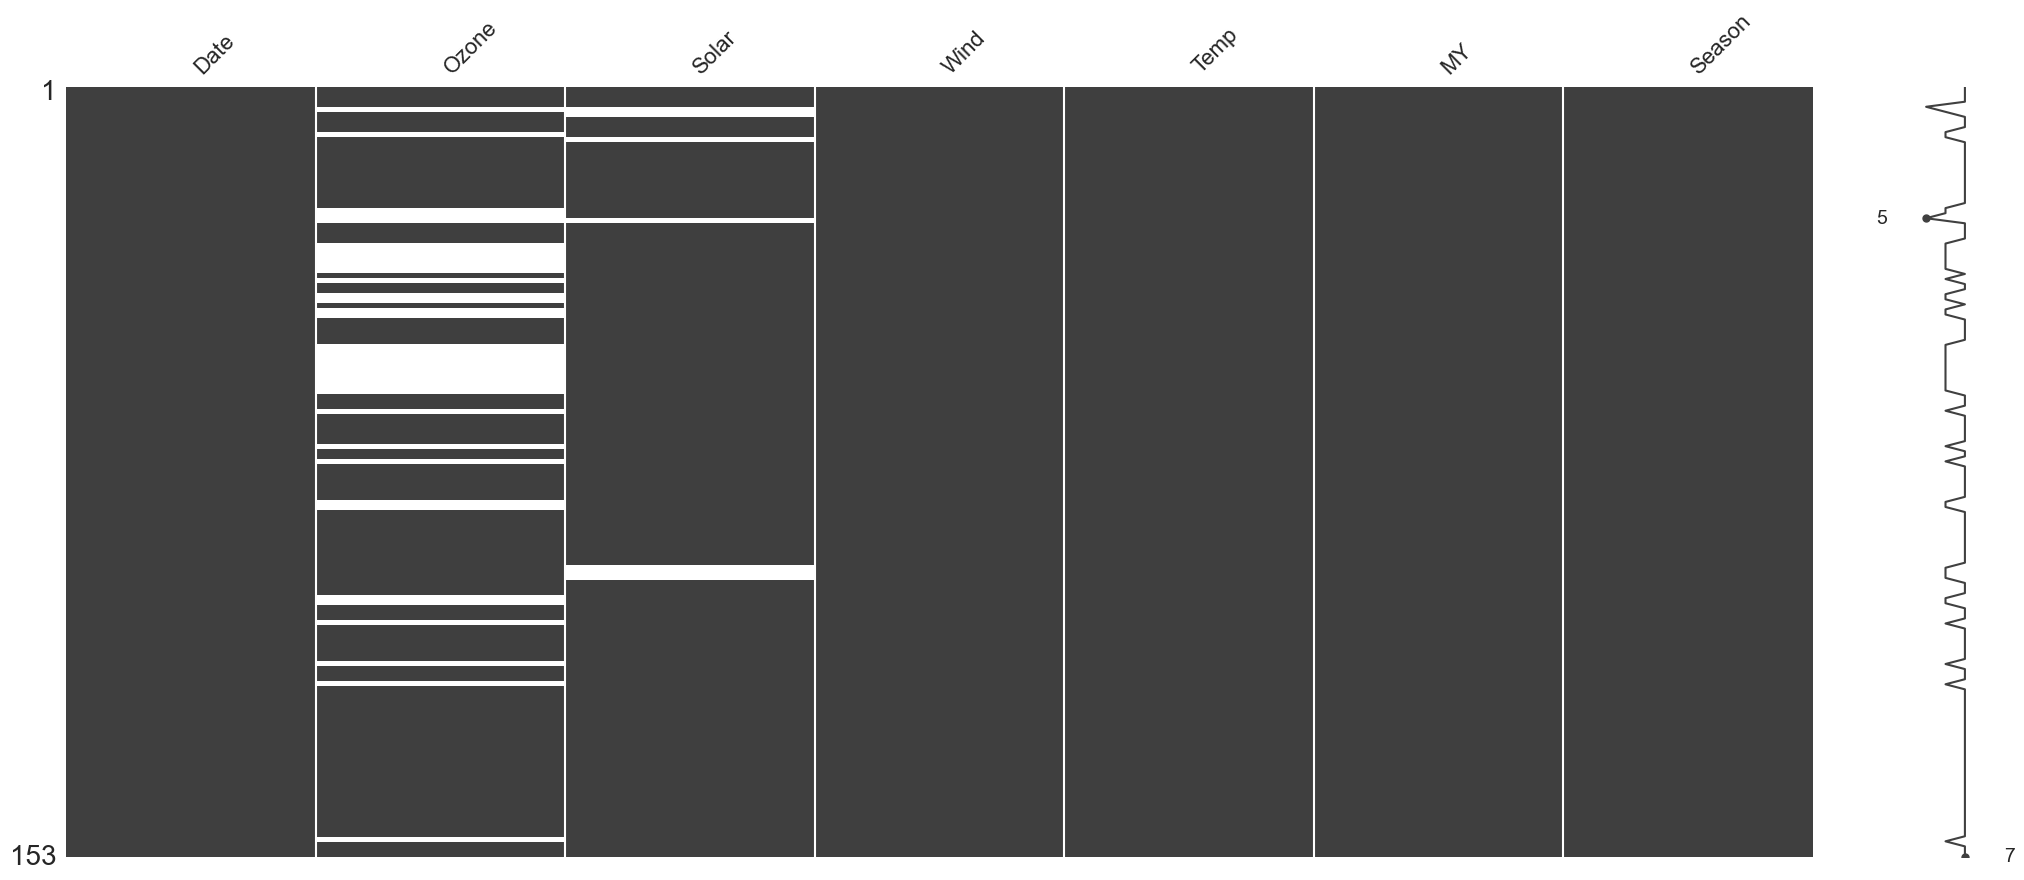

In [9]:
msno.matrix(air)

## Identify type of missing

<Axes: >

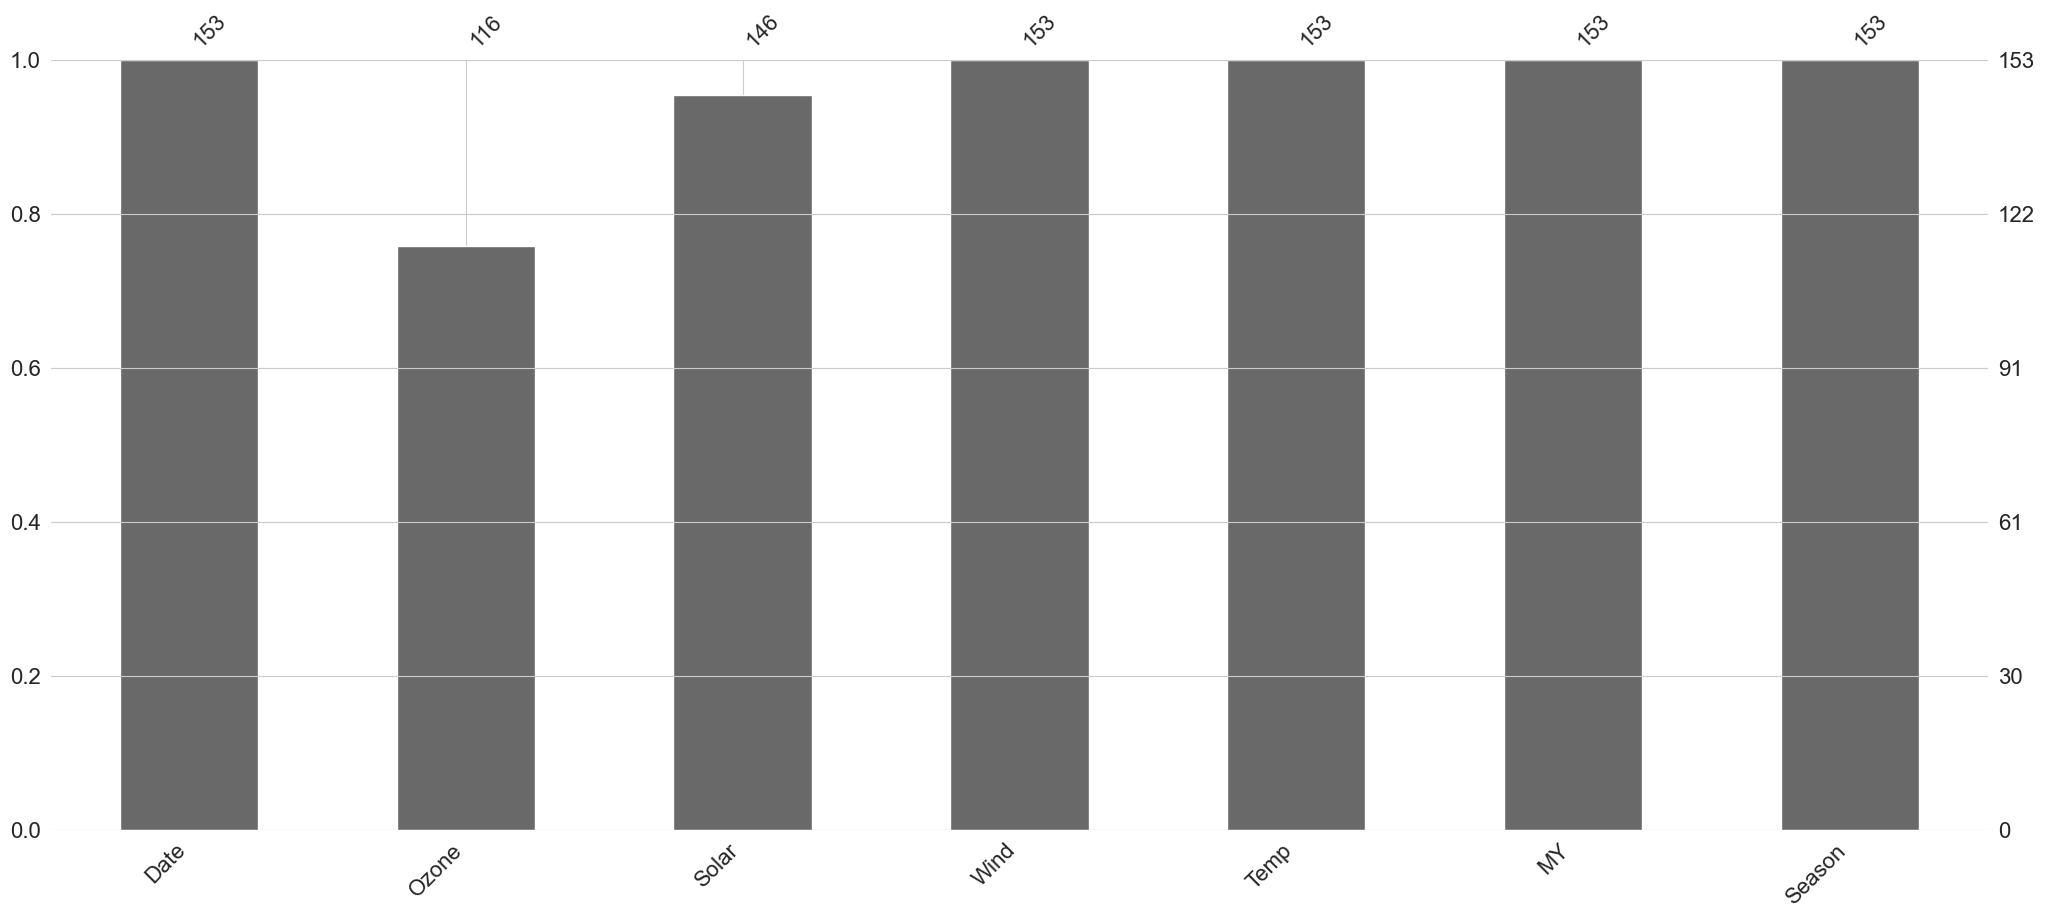

In [10]:
msno.bar(air)

<Axes: >

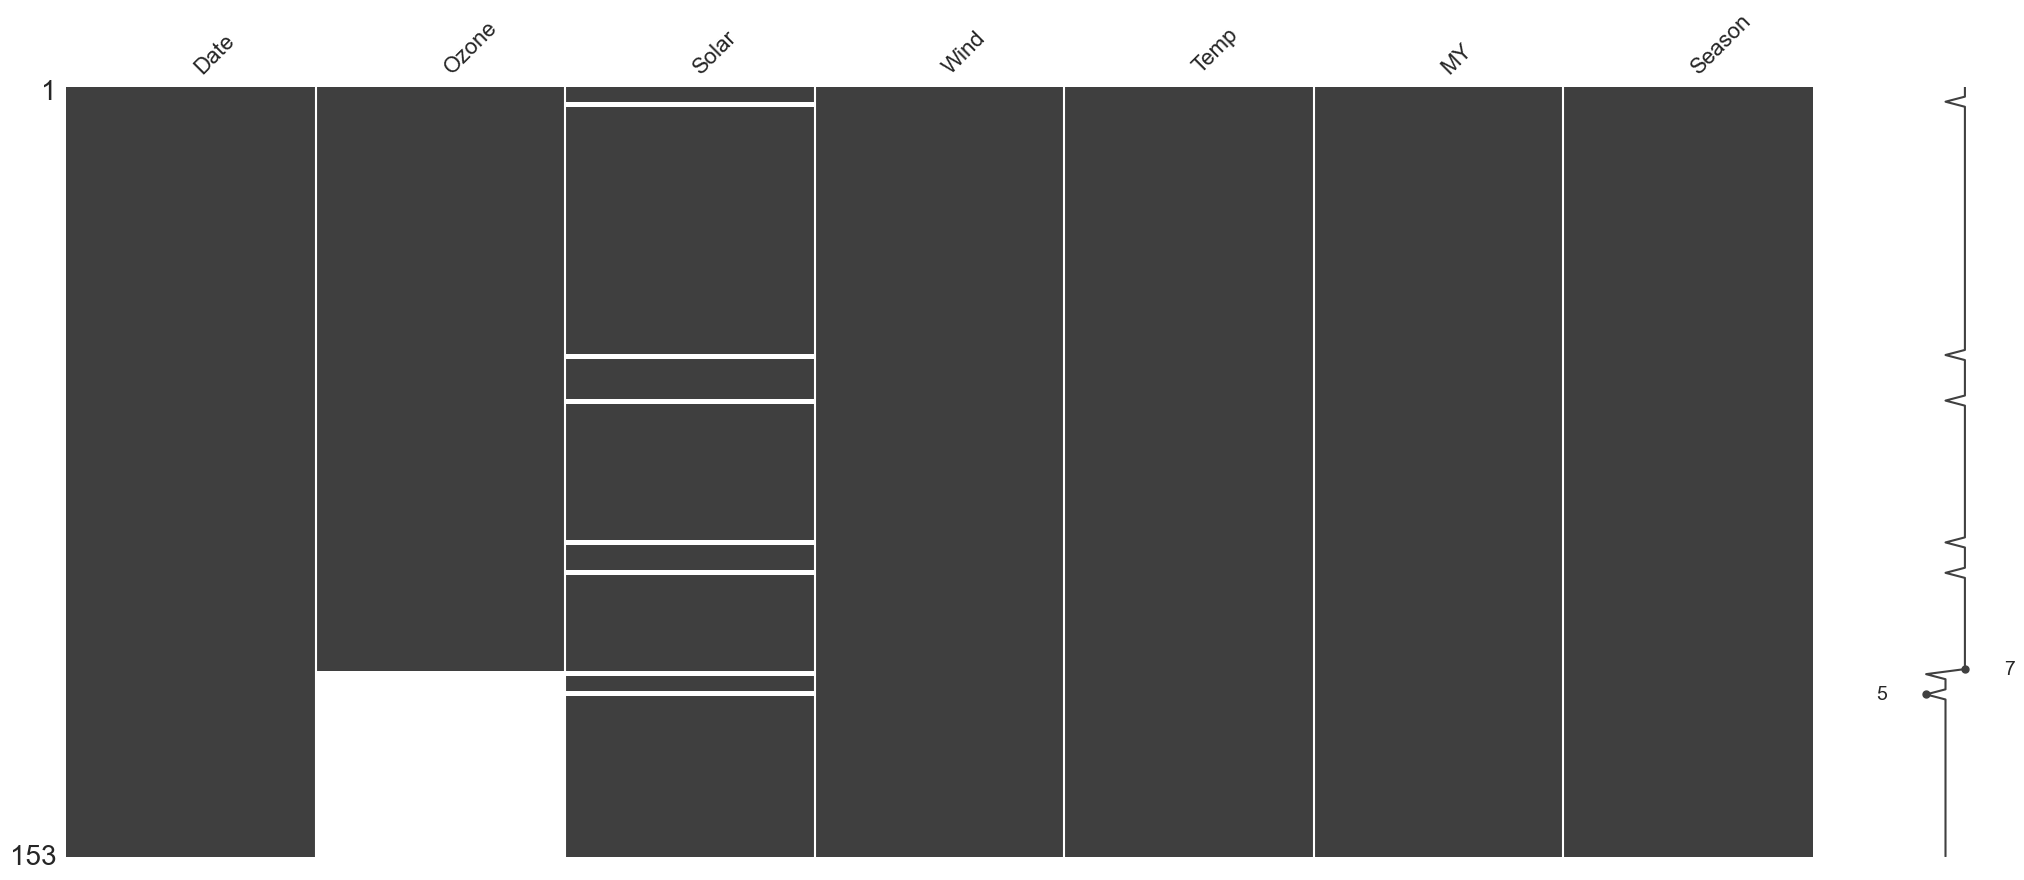

In [11]:
msno.matrix(air.sort_values(by='Ozone'))

<Axes: xlabel='Ozone', ylabel='Solar'>

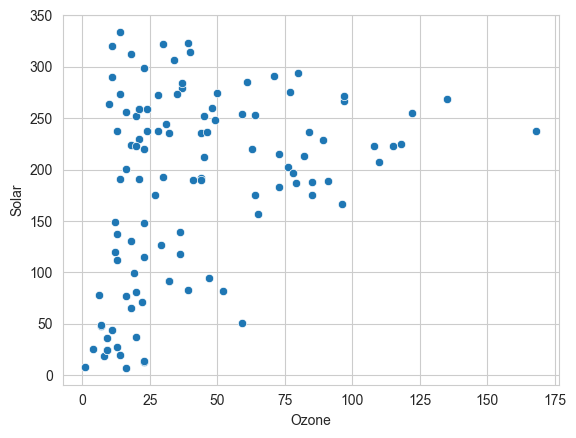

In [12]:
import seaborn as sns
sns.scatterplot(data=air, x='Ozone', y='Solar')

In [13]:
## pearson corr
print(air['Ozone'].corr(air['Solar']))

## Spearman rho
print(air['Ozone'].corr(air['Solar'], method='spearman'))

## Non-Linear relationship 

0.3483416929936026
0.34818646995676306


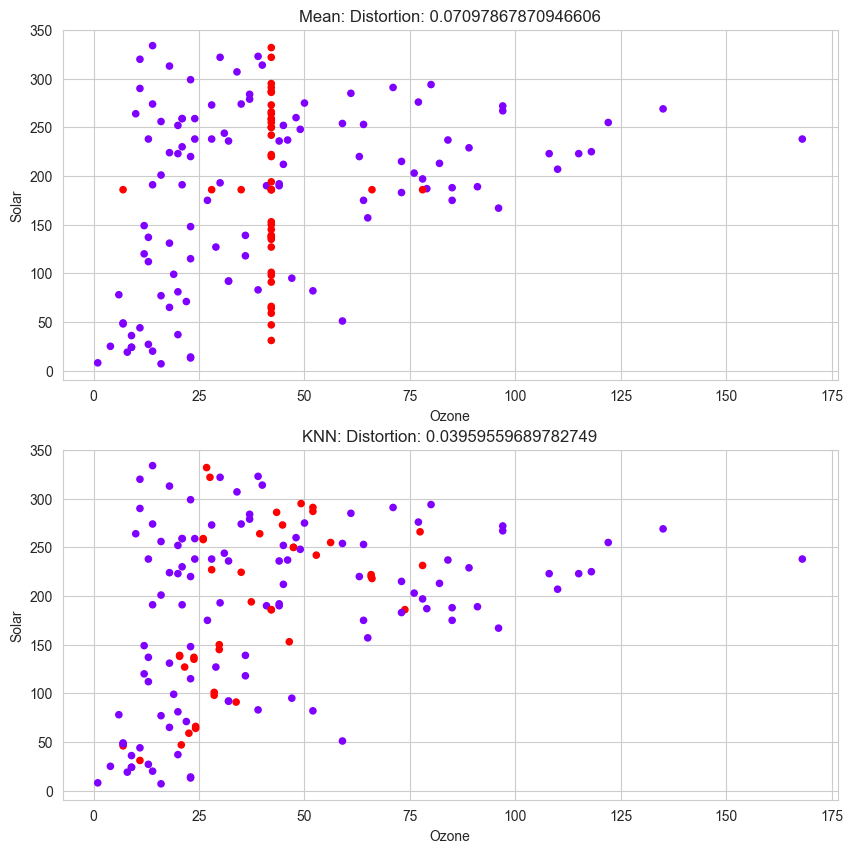

In [14]:
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

mean_clean = air.copy(deep=True)[['Ozone', 'Solar']]
KNN_clean = air.copy(deep=True)[['Ozone', 'Solar']]

mean_imp = SimpleImputer(strategy='mean')
knn_imp = KNNImputer()



mean_clean.iloc[:,:] = mean_imp.fit_transform(mean_clean)
KNN_clean.iloc[:,:] = knn_imp.fit_transform(KNN_clean)

fig, axes = plt.subplots(nrows =2, ncols=1, figsize=(10,10))

nullity = air.Ozone.isnull() + air['Solar'].isnull()

imputations = {'Mean':mean_clean, 'KNN':KNN_clean}

for ax, imputation in zip(axes.flatten(), imputations):
    data = imputations[imputation]
    method = imputation
    new_relationship = data.Solar.corr(data.Ozone, method='spearman')
    distortion = np.abs(new_relationship - air.Solar.corr(air.Ozone, method='spearman'))

    data.plot(kind='scatter', x='Ozone', y='Solar', title=f'{method}: Distortion: {distortion}',
              c=nullity, colormap='rainbow', colorbar=False, ax=ax)

In [15]:
air[['Ozone', 'Solar']] = KNN_clean[['Ozone', 'Solar']]

<Axes: >

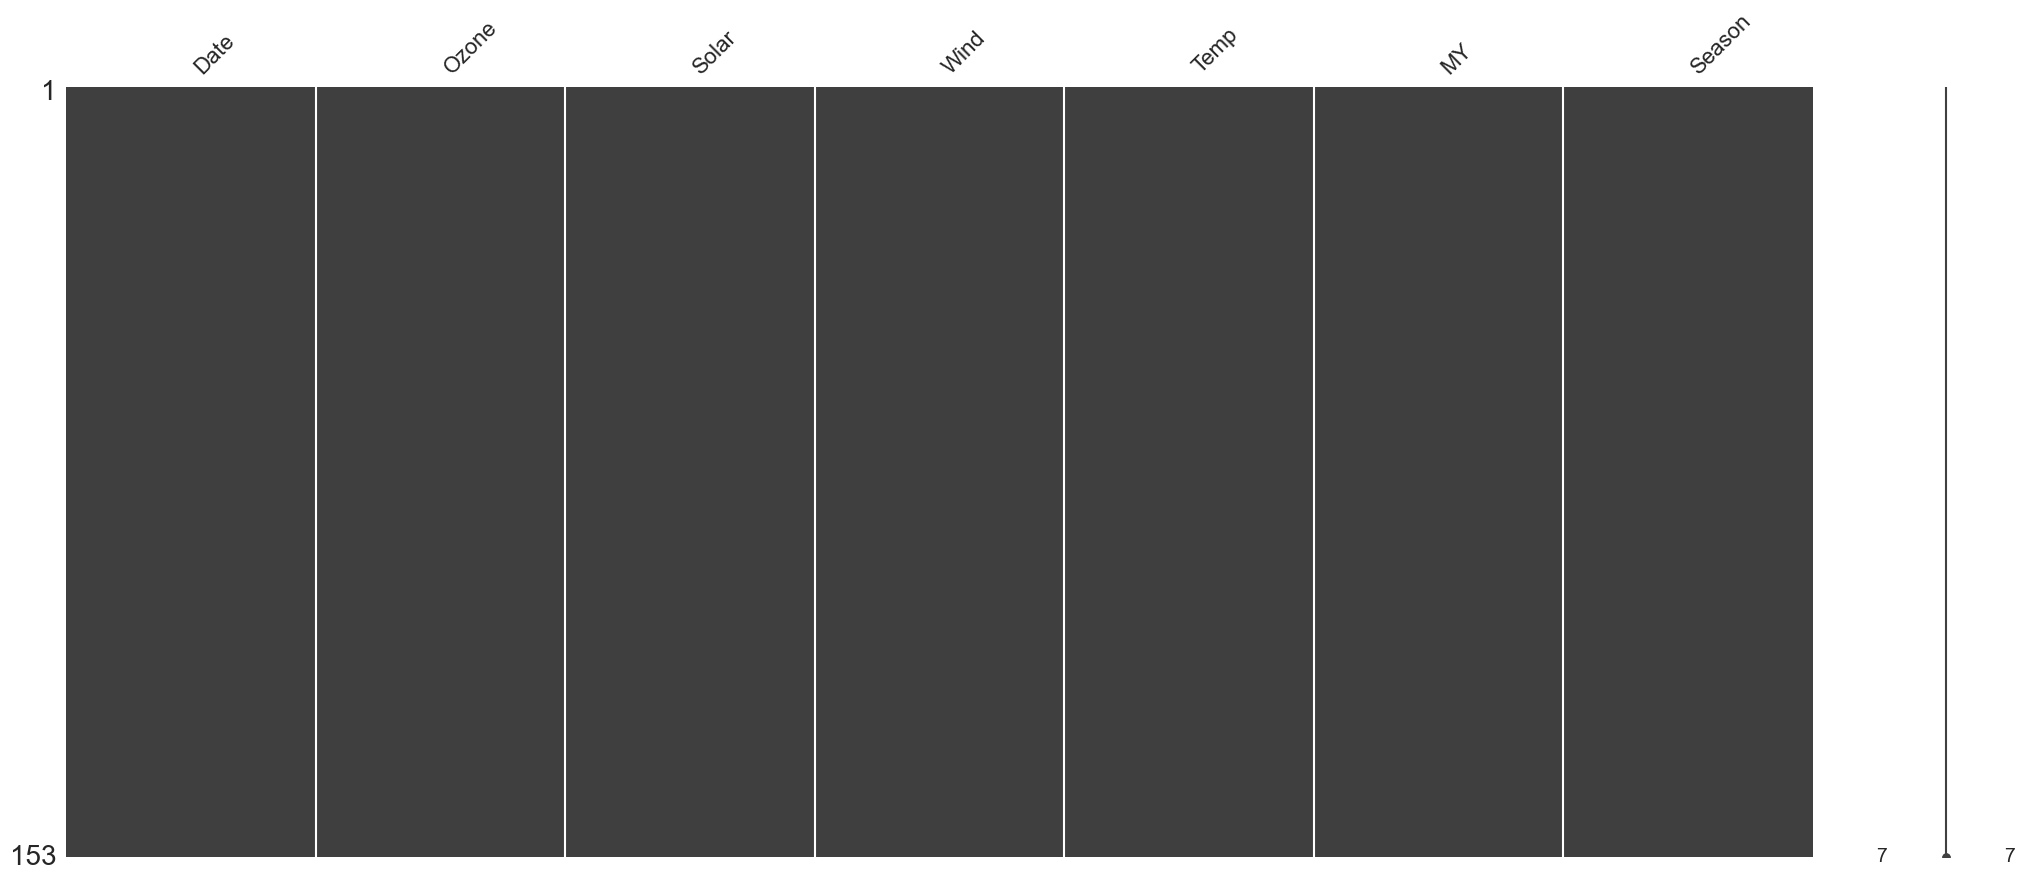

In [16]:
msno.matrix(air)

## EDA

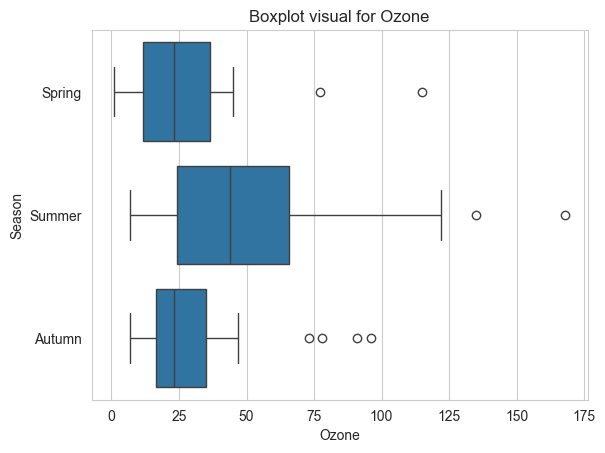

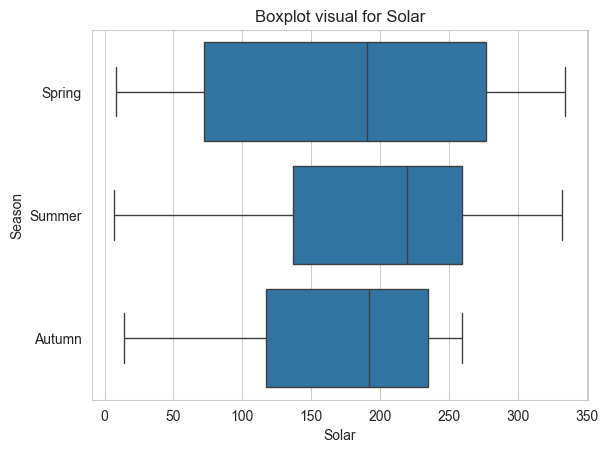

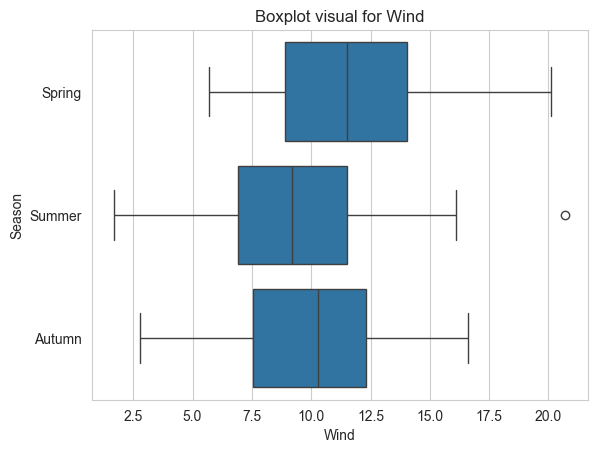

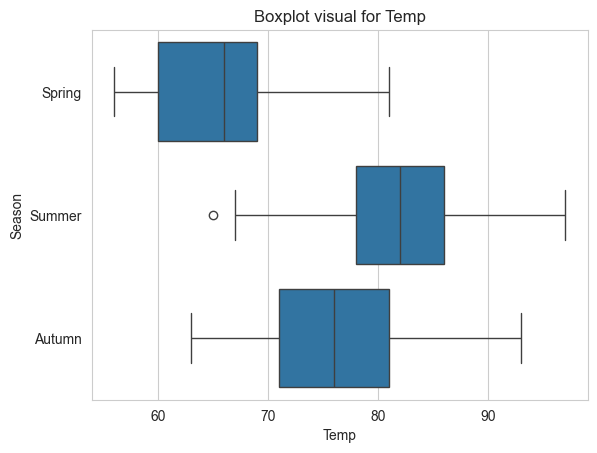

In [17]:
for x in air.select_dtypes(include='number').columns:
    sns.boxplot(x= air[x], y = air['Season'])
    plt.title(f'Boxplot visual for {x}')
    plt.show()

## Histograms

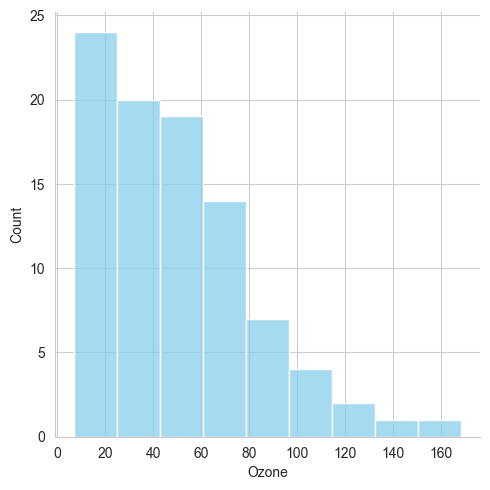

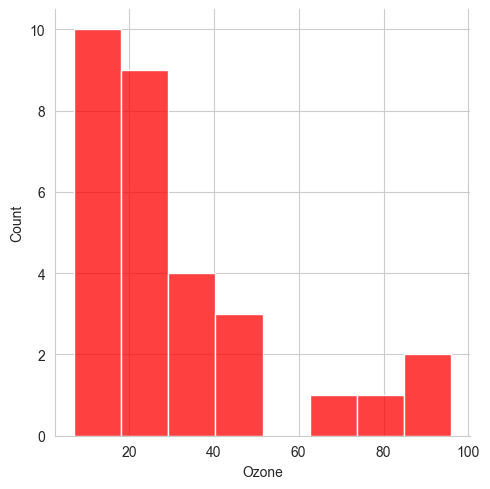

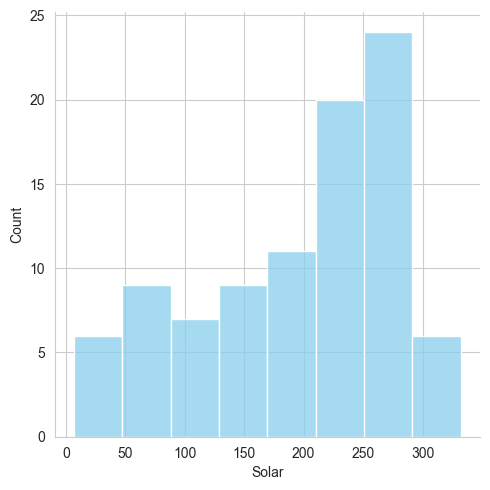

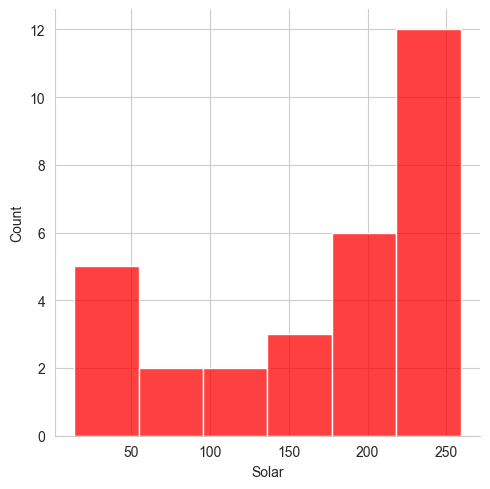

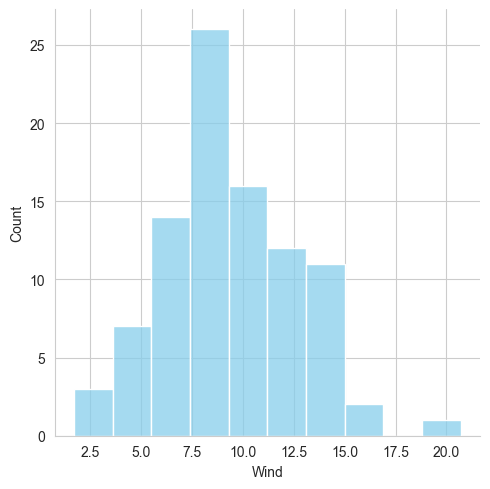

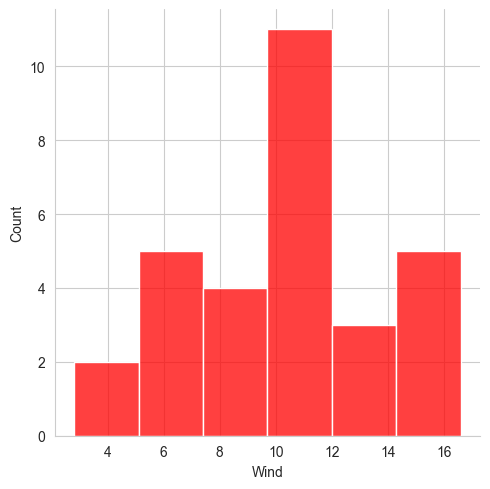

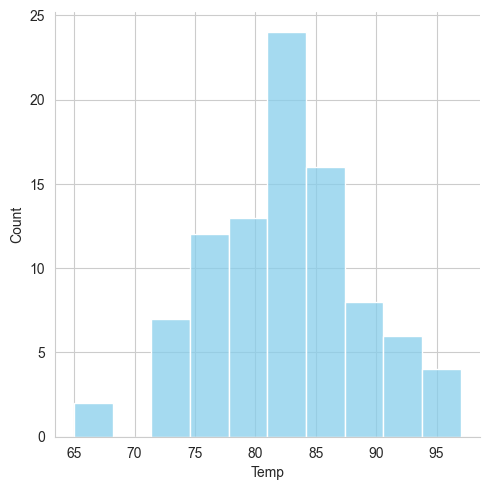

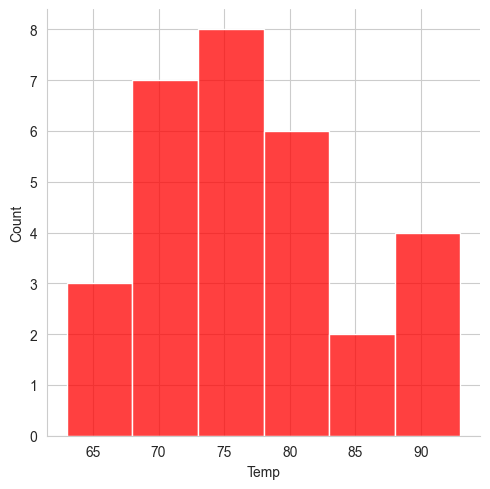

In [18]:
for x in air.select_dtypes(include='number').columns:
    sns.displot(x= air[x][air['Season']=='Summer'], color='skyblue', label='Summer')
    sns.displot(x= air[x][air['Season']=='Autumn'], color='red', label='Autumn')
    plt.show()

## t-Test on variables from different seasons

In [19]:
from scipy import stats
from itertools import combinations as it_combinations
numerical_values = air.select_dtypes(include='number').columns
significant_pairs = {k: [] for k in numerical_values}

for x in numerical_values:
    seasons = air['Season'].dropna().unique()
    for s1, s2 in it_combinations(seasons, 2):
        a = air.loc[air['Season'] == s1, x].dropna()
        b = air.loc[air['Season'] == s2, x].dropna()
        if len(a) > 1 and len(b) > 1:
            stat, pv = stats.ttest_ind(a, b, equal_var=False)
            print(f'Welch t-test {s1} vs {s2}, for variable {x}: p={pv:.4g}')
            if pv < 0.05:
                significant_pairs[x].append((s1, s2))
significant_pairs

Welch t-test Spring vs Summer, for variable Ozone: p=7.605e-05
Welch t-test Spring vs Autumn, for variable Ozone: p=0.466
Welch t-test Summer vs Autumn, for variable Ozone: p=0.00177
Welch t-test Spring vs Summer, for variable Solar: p=0.467
Welch t-test Spring vs Autumn, for variable Solar: p=0.6474
Welch t-test Summer vs Autumn, for variable Solar: p=0.1137
Welch t-test Spring vs Summer, for variable Wind: p=0.002624
Welch t-test Spring vs Autumn, for variable Wind: p=0.1125
Welch t-test Summer vs Autumn, for variable Wind: p=0.2426
Welch t-test Spring vs Summer, for variable Temp: p=3.811e-16
Welch t-test Spring vs Autumn, for variable Temp: p=3.309e-07
Welch t-test Summer vs Autumn, for variable Temp: p=0.002101


{'Ozone': [('Spring', 'Summer'), ('Summer', 'Autumn')],
 'Solar': [],
 'Wind': [('Spring', 'Summer')],
 'Temp': [('Spring', 'Summer'), ('Spring', 'Autumn'), ('Summer', 'Autumn')]}

## Effect sizes

In [20]:
def eta_coef(categories, values):

    ## force inputs to be np arrays for purpose of mathematical calculations
    categories = np.array(categories)
    values = np.array(values)

    ## create bins
    effect_sizes = [0.06,0.14]

    ## label for the effect
    effect_labels = ['Small', 'Medium', 'Large']

    ss_e = 0
    ss_g = 0
    for category in set(categories):
        subgroup = values[np.where(categories == category)[0]]
        ss_e += sum((subgroup-np.mean(subgroup))**2)
        ss_g += len(subgroup) * ((np.mean(subgroup) - np.mean(values))**2)
    
    effect_size = effect_labels[int(np.digitize([(ss_g/(ss_e + ss_g))], effect_sizes, right= False)[0])]

    return effect_size, (ss_g/(ss_e + ss_g))

In [21]:
for num in numerical_values:
    print(f"Effect of season on {num}: {eta_coef(air['Season'], air[num])[0]}")
    for other in numerical_values[numerical_values != num]:
        r = stats.pearsonr(air[num], air[other]).correlation
        print(f'Explained variance of {num} vs {other}: {r**2}')
    print('----------------------------------------------------------------\n\n')

Effect of season on Ozone: Medium
Explained variance of Ozone vs Solar: 0.1374027671583727
Explained variance of Ozone vs Wind: 0.25541180121364815
Explained variance of Ozone vs Temp: 0.34123352367868104
----------------------------------------------------------------


Effect of season on Solar: Small
Explained variance of Solar vs Ozone: 0.1374027671583727
Explained variance of Solar vs Wind: 0.0024993715878067124
Explained variance of Solar vs Temp: 0.07154214626693264
----------------------------------------------------------------


Effect of season on Wind: Medium
Explained variance of Wind vs Ozone: 0.25541180121364815
Explained variance of Wind vs Solar: 0.0024993715878067124
Explained variance of Wind vs Temp: 0.20975289740694314
----------------------------------------------------------------


Effect of season on Temp: Large
Explained variance of Temp vs Ozone: 0.34123352367868104
Explained variance of Temp vs Solar: 0.07154214626693264
Explained variance of Temp vs Wind: 0

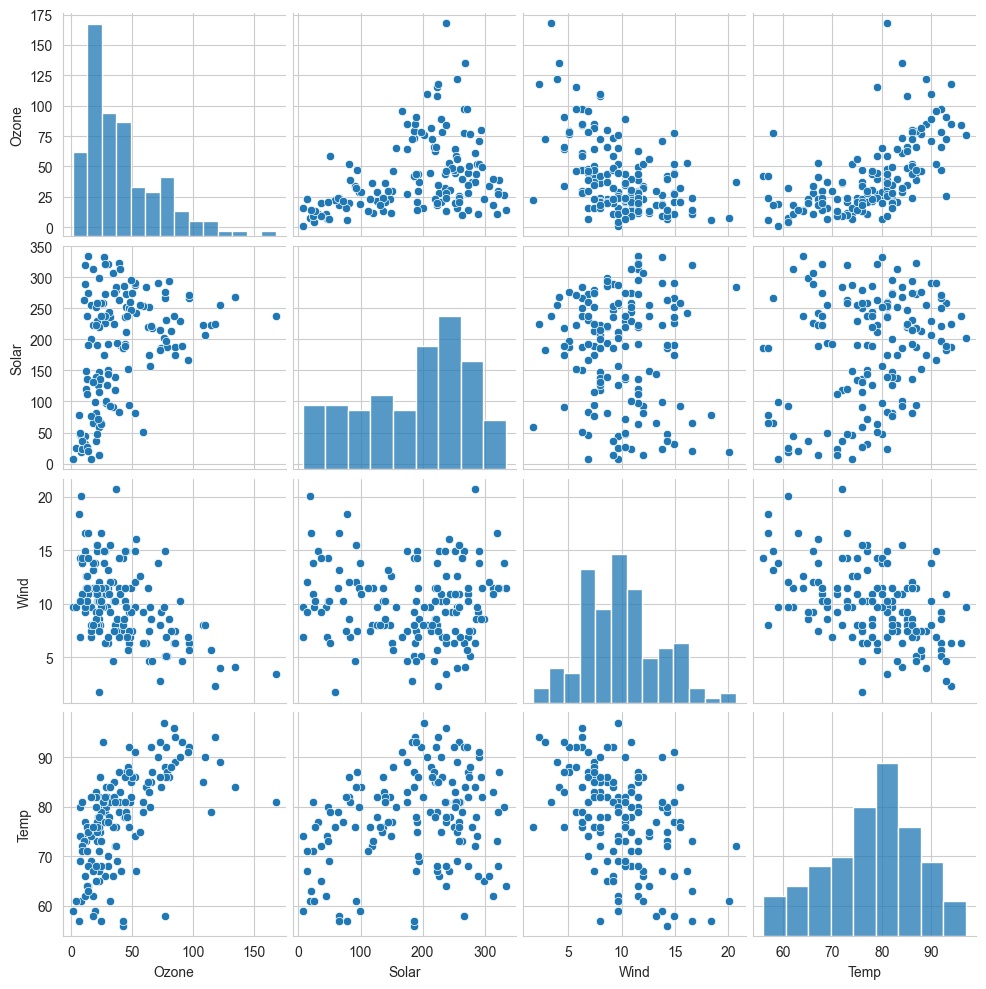

In [22]:
sns.pairplot(data=air)

In [2]:
# Feature selection is SUPER important
# RFE votes out features that aren't necessary
# Model Scaling. Model scalling.
# stratify, y. Look at the effect of stratification vs not.
# Fit and transform with X_train and X_test
# Lasso penalises coefficients.
# l2 also called ridge.
# Tune model after cross-validation. Hyperparameters tuning. A Look into hyperparameter.
#